In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc("font", size=18, family="serif")
import yt
import numpy as np
import matplotlib.pyplot as plt
from yt.utilities.physical_ratios import cm_per_kpc, K_per_keV
from yt.units import mp
import pyxsim
import soxs
import aplpy
import matplotlib.colors as colors


/mnt/lustre/ast2/astadit/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/mnt/lustre/ast2/astadit/anaconda3/lib/python3.7/site-packages/pyxsim/source_generators/light_cone.py:11: VisibleDeprecationWarning: Development of the CosmologySplice module has been moved to the yt_astro_analysis package. This version is deprecated and will be removed from yt in a future release. See https://github.com/yt-project/yt_astro_analysis for further information.
  from yt.analysis_modules.cosmological_observation.api import LightCone
/mnt/lustre/ast2/astadit/anaconda3/lib/python3.7/site-packages/yt/analysis_modules/cosmological_observation/api.py:28: VisibleDeprecationWarning: Development of the LightCone module has been moved to the yt_astro_analysis package. This version is deprecated and will be removed from yt in a future release. See https://githu

In [2]:
plt.rcParams['font.size']=20
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size']=10
plt.rcParams['xtick.minor.size']=5
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.width']=1
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.major.size']=10
plt.rcParams['ytick.minor.size']=5
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.width']=1
plt.rcParams['ytick.direction']='in'

In [6]:
# base     = "/home/aditiv/CGM/Pyxsim/Data/"
base    = "/mnt/lustre/ast2/astadit/CGM/Pyxsim/Data/"
folder   = ["HR_0821_1e-6_SFR3/", "HR_0821_n6e-5_T1e6_hse_SFR10_Rsf2kpc/" ]


filename = ["DD0300/sb_0300", "DD0130/sb_0130"]

run_name =[ r'n1e-6$\Sigma$3M$_{\odot}$' , r'n6e-5$\Sigma$10M$_{\odot}$']

In [7]:
run = len(filename)
x = np.zeros((run,128))
y = np.zeros((run,128))
z = np.zeros((run,128, 128))
temp = np.zeros((run,128))
dens = np.zeros((run,128))
cellmT = np.zeros((run,128))
cellmD = np.zeros((run,128))

for i in range(run):
    ds       = yt.load(base + folder[i] + filename[i])


    sp1       = ds.sphere('c',(400,'kpc'))
    cr        = sp1.cut_region(" (obj['z'].in_units('kpc')<6) & (obj['z'].in_units('kpc')>-6)\
                       & (obj['radius'].in_units('kpc')<20)  " )

    sp        = sp1 - cr

    sp050     = sp.cut_region(["(obj['radius'].in_units('kpc') <= 50.)  & \
                                (obj['radius'].in_units('kpc') > 0) "])

    (dlow,  dhigh)  = (sp050.quantities.extrema('density')[0],    sp050.quantities.extrema('density')[1])
    (tplow, tphigh) = (sp050.quantities.extrema('temperature')[0],sp050.quantities.extrema('temperature')[1])


    extrema = dict(density=(dlow, dhigh), temperature=(tplow,tphigh))

    profile = yt.create_profile(sp050, ['density','temperature'],
                                n_bins=[128, 128], fields=['cell_mass'],
                                weight_field=None, extrema=extrema)


    x[i] = profile.x
    y[i] = profile.y
    b = profile.field_data
    z[i,:,:] = b[('gas', 'cell_mass')]
    
    
    profile1   = yt.create_profile(sp050,   ["temperature"],fields=["cell_mass"],\
                                  n_bins=[128, 128], weight_field=None, accumulation=False)
    temp[i,:]  = profile1.x
    cellmT[i,] = profile1["cell_mass"]
    
    
    profile2   = yt.create_profile(sp050,   ["density"],fields=["cell_mass"],\
                                  n_bins=[128, 128],weight_field=None, accumulation=False)
    dens[i,:]  = profile2.x
    cellmD[i,:]= profile2["cell_mass"]


yt : [INFO     ] 2020-04-11 11:53:50,082 Parameters: current_time              = 3000.0001595029
yt : [INFO     ] 2020-04-11 11:53:50,083 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2020-04-11 11:53:50,085 Parameters: domain_left_edge          = [-4. -4. -4.]
yt : [INFO     ] 2020-04-11 11:53:50,086 Parameters: domain_right_edge         = [4. 4. 4.]
yt : [INFO     ] 2020-04-11 11:53:50,087 Parameters: cosmological_simulation   = 0.0
Parsing Hierarchy : 100%|██████████| 481/481 [00:00<00:00, 7636.83it/s]
yt : [INFO     ] 2020-04-11 11:53:50,178 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2020-04-11 11:55:15,245 Parameters: current_time              = 1299.9999474465
yt : [INFO     ] 2020-04-11 11:55:15,248 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2020-04-11 11:55:15,249 Parameters: domain_left_edge          = [-4. -4. -4.]
yt : [INFO     ] 2020-04-11 11:55:15,250 Parameters: domain_right_edge         = [4. 4.

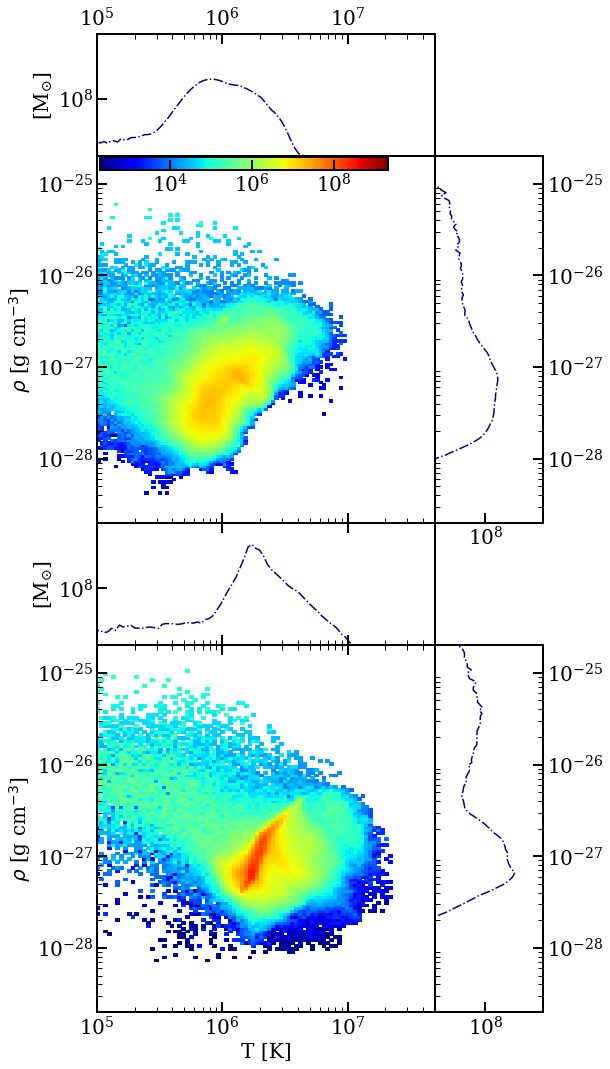

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
Msun = 1.e33
majorLocator = MultipleLocator(2)
majorFormatter = FormatStrFormatter('%d')

f, ax = plt.subplots(2, 1, gridspec_kw = {'hspace':0.0,},figsize=(8,18))


for i in range(2):
    divider = make_axes_locatable(ax[i])

    plot = ax[i].pcolormesh(y[i],x[i],z[i,:,:]/Msun, norm=colors.LogNorm(vmin=2e35/Msun, vmax=2.e42/Msun),
                   cmap='jet')


    axHistx = divider.append_axes("top", size=1.7, pad=0, sharex=ax[i])
    axHisty = divider.append_axes("right", size=1.5, pad=0, sharey=ax[i])
    axHistx.set_ylim(2.e39/Msun, 9.e42/Msun)
    axHisty.set_xlim(2.e39/Msun, 9.e42/Msun)
    
    axHistx.plot(temp[i,:],cellmT[i,:]/Msun, '-.', color = 'darkblue')
    axHisty.plot(cellmD[i,:]/Msun,dens[i,:], '-.', color = 'darkblue')
    
    axHistx.set_yscale('log')
    axHisty.set_xscale('log')
    
    
    axHistx.tick_params(axis='y', which='minor', left=True)
    
    axHisty.tick_params(axis='y', which='minor', left=False, right=True)
    
    ax[i].tick_params(axis='x', labelbottom=False)
    

    if(i==0): 
        axHistx.tick_params(axis='x', which='minor', bottom=False, top=True)    
        axHistx.tick_params(axis='x', top =True, bottom=False, labelbottom=False, labeltop = True) 
   
    else:    
        axHistx.tick_params(axis='x', top =True, bottom=True, labelbottom=False, labeltop = False)
        ax[i].tick_params(axis='x', which='both', top=True)

        
    axHisty.tick_params(axis='y', left=False, right=True, labelleft=False, labelright = True)
    axHisty.tick_params(axis='y', which = 'minor', left=True)
    
    axHistx.set_ylabel("[M$_{\odot}$]")
    
    if(i==2): 
        axHisty.set_xlabel("[M$_{\odot}$]")
        ax[i].tick_params(axis='x', labelbottom=True)


    ax[i].set_ylabel(r'$\rho$ [g cm$^{-3}$]')
    ax[1].set_xlabel(r'T [K]')
    axHisty.tick_params(axis='x', which='minor', bottom=True, top=True)
    ax[1].tick_params(axis='x', labelbottom=True)
    
    if(i==0):
        cax = f.add_axes([0.13, 0.775, 0.5, 0.01])
        f.colorbar(plot, cax=cax, orientation='horizontal')


plt.setp(ax,'yscale','log')
plt.setp(ax,'xscale','log')
plt.setp(ax, 'xlim', (1.e5, 5.e7))

plt.setp(ax, 'ylim', (2.e-29, 2.e-25))
# plt.savefig('2DX1D_histo.pdf', bbox_inches= 'tight', dpi=160)
plt.show()
